# 1. Install dependencies

In [13]:
!pip install psycopg2-binary pandas numpy matplotlib plotly faker requests umap-learn tabulate

# 2. Imports

In [14]:
import os, requests
import psycopg2
import pandas as pd
import numpy as np
from io import StringIO
import plotly.express as px


# 3. Connect to PostgreSQL with pgvector

In [15]:
conn = psycopg2.connect(
    dbname="patient_db",
    user="kevin",
    password="password123",
    host="localhost",
    port=6432
)
cur = conn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
conn.commit()


# 4. Load CSVs

In [16]:
patients_df = pd.read_csv("data/patients.csv")
allergies_df = pd.read_csv("data/allergies.csv")

print("Patients:")
display(patients_df.head())

print("Allergies:")
display(allergies_df.head())


Patients:


,patient_id,vista_id,mrn,first_name,last_name,middle_name,gender,birthdate,age,race,...,genetic_markers,precision_markers,comorbidity_profile,care_plan_total,care_plan_completed,care_plan_overdue,care_plan_scheduled,deceased,death_date,death_primary_cause
0,6ff1fecb-2e56-48ee-b409-536e2c4bd516,811395,MRN562898,Kelly,Logan,A,female,1993-11-07,32,Asian,...,[],[],[],0,0,0,0,False,NaN,NaN
1,89e85025-1b35-4ab0-a047-d40d150bde21,8666457,MRN654326,Margaret,Thompson,T,female,1952-11-17,73,Black,...,[],[],[],0,0,0,0,False,NaN,NaN
2,65612562-1759-4972-977b-63eeda4e207c,999822,MRN490696,Sarah,Parker,C,other,1958-11-16,67,Hispanic,...,[],[],[],0,0,0,0,False,NaN,NaN
3,6bccb32e-bc3d-4b37-ba9d-39aaa2a2aa18,4252671,MRN783682,Peter,Hicks,A,female,1943-11-20,82,Black,...,[],[],"[{""primary"": ""Hypertension"", ""associated"": ""Di...",0,0,0,0,False,NaN,NaN
4,c9c8637c-b595-4fae-9090-0c8881cb7934,8024696,MRN636006,Julie,Hancock,K,female,1986-11-09,39,Native American,...,[],"[{""condition"": ""Diabetes"", ""marker"": ""GAD_Anti...","[{""primary"": ""Hypertension"", ""associated"": ""Di...",3,1,2,0,False,NaN,NaN


Allergies:


,allergy_id,patient_id,substance,category,reaction,reaction_code,reaction_system,severity,severity_code,severity_system,rxnorm_code,unii_code,snomed_code,risk_level,registry_source,recorded_date,followup_summary
0,3c8fae02-3b56-4a17-9773-eec6db8f910c,65612562-1759-4972-977b-63eeda4e207c,Banana 100 Mg/Ml Injectable Solution,food,Itching,418290006,http://snomed.info/sct,severe,24484000,http://snomed.info/sct,891833,NaN,NaN,standard,warehouse,1998-11-24,risk: standard | severity: severe | medication...
1,c543df84-2413-471c-bc1e-c2a38ea4082a,6bccb32e-bc3d-4b37-ba9d-39aaa2a2aa18,Buckwheat 50 Mg/Ml Injectable Solution,food,Anaphylaxis,39579001,http://snomed.info/sct,mild,255604002,http://snomed.info/sct,899397,NaN,NaN,standard,warehouse,1966-11-05,risk: standard | severity: mild
2,b64e9d02-d768-44b2-bcd2-ce40f8acc868,4b743fa5-398e-44ab-8fce-abf1fdb5eec7,Common Paper Wasp Venom,insect,Vomiting,422400008,http://snomed.info/sct,mild,255604002,http://snomed.info/sct,1294628,NaN,NaN,standard,warehouse,1994-01-26,risk: standard | severity: mild
3,ba6c97e7-9ad2-4570-b8a3-820473a90973,0e67e48e-cb07-43cb-834b-dab0da3f3933,Allscale Pollen,environment,Vomiting,422400008,http://snomed.info/sct,mild,255604002,http://snomed.info/sct,897304,NaN,NaN,standard,warehouse,2017-06-01,risk: standard | severity: mild
4,8c333ec4-8087-40bb-9fa6-cf1168703a08,97ab3423-de81-4c2c-866f-8c5cf6edf6f1,American Elm Pollen 40000 Unt/Ml Injectable So...,environment,Vomiting,422400008,http://snomed.info/sct,mild,255604002,http://snomed.info/sct,889556,NaN,NaN,standard,warehouse,1963-05-03,risk: standard | severity: mild


# 5. Create normalized tables

In [17]:
conn.rollback()

cur.execute("""
DROP TABLE IF EXISTS allergies CASCADE;
DROP TABLE IF EXISTS patients CASCADE;

CREATE TABLE patients (
    patient_id TEXT PRIMARY KEY,
    vista_id TEXT,
    mrn TEXT,
    first_name TEXT,
    last_name TEXT,
    middle_name TEXT,
    gender TEXT,
    birthdate TEXT,          -- changed from DATE to TEXT for flexibility
    age INT,
    race TEXT,
    ethnicity TEXT,
    address TEXT,
    city TEXT,
    state TEXT,
    zip TEXT,
    country TEXT,
    phone TEXT,
    email TEXT,
    marital_status TEXT,
    language TEXT,
    insurance TEXT,
    ssn TEXT,
    smoking_status TEXT,
    alcohol_use TEXT,
    education TEXT,
    employment_status TEXT,
    income TEXT,
    housing_status TEXT,
    sdoh_risk_score FLOAT,
    sdoh_risk_factors TEXT,
    community_deprivation_index FLOAT,
    access_to_care_score FLOAT,
    transportation_access TEXT,
    language_access_barrier TEXT,
    social_support_score FLOAT,
    sdoh_care_gaps TEXT,
    genetic_risk_score FLOAT,
    genetic_markers TEXT,
    precision_markers TEXT,
    comorbidity_profile TEXT,
    care_plan_total INT,
    care_plan_completed INT,
    care_plan_overdue INT,
    care_plan_scheduled INT,
    deceased BOOLEAN,
    death_date TEXT,         -- also TEXT now
    death_primary_cause TEXT
);

CREATE TABLE allergies (
    allergy_id TEXT PRIMARY KEY,
    patient_id TEXT,
    substance TEXT,
    category TEXT,
    reaction TEXT,
    reaction_code TEXT,
    reaction_system TEXT,
    severity TEXT,
    severity_code TEXT,
    severity_system TEXT,
    rxnorm_code TEXT,
    unii_code TEXT,
    snomed_code TEXT,
    risk_level TEXT,
    registry_source TEXT,
    recorded_date TEXT,
    followup_summary TEXT
);
""")
conn.commit()
print("✅ Tables recreated successfully")


✅ Tables recreated successfully


# 6. Bulk-insert dataframes into Postgres

In [18]:
from io import StringIO

def copy_dataframe(df, table_name):
    # Make sure nulls are proper SQL NULLs
    df = df.replace({np.nan: None})

    # Write DataFrame to CSV buffer with quoting handled by pandas
    buffer = StringIO()
    df.to_csv(
        buffer,
        index=False,
        header=False,
        sep=",",
        quoting=1,  # csv.QUOTE_ALL
        escapechar="\\"
    )
    buffer.seek(0)

    try:
        cur.copy_expert(
            sql=f"COPY {table_name} FROM STDIN WITH (FORMAT CSV, HEADER FALSE, DELIMITER ',', QUOTE '\"', ESCAPE '\\')",
            file=buffer
        )
        conn.commit()
        print(f"✅ Loaded {len(df)} rows into {table_name}")
    except Exception as e:
        conn.rollback()
        print(f"❌ Error loading {table_name}: {e}")

# --- Clean and normalize the patients dataframe ---
patients_df = patients_df.replace({np.nan: None})  # Convert NaN to None

# Normalize date columns: replace blanks with None, cast to str for CSV writing
for col in ["birthdate", "death_date"]:
    patients_df[col] = patients_df[col].apply(lambda x: None if pd.isna(x) or x == "" else str(x))

# --- Filter allergies to valid patient_ids ---
allergies_df = allergies_df[allergies_df["patient_id"].isin(patients_df["patient_id"])].copy()

# Confirm how many rows remain
print(f"Patients: {len(patients_df)} | Allergies (filtered): {len(allergies_df)}")
# Run it
copy_dataframe(patients_df, "patients")
copy_dataframe(allergies_df, "allergies")


Patients: 100 | Allergies (filtered): 97
✅ Loaded 100 rows into patients
✅ Loaded 97 rows into allergies


# 7. Join data into patient “context” paragraphs

In [19]:
# --- Step 7 (replace completely) ---
query = """
WITH agg AS (
  SELECT
    p.patient_id,
    p.first_name, p.last_name, p.gender, p.age, p.race, p.ethnicity,
    p.sdoh_risk_score,
    CASE
      WHEN p.sdoh_risk_score >= 0.70 THEN 'HIGH'
      WHEN p.sdoh_risk_score >= 0.40 THEN 'MEDIUM'
      ELSE 'LOW'
    END AS sdoh_bucket,
    COALESCE(p.insurance, 'Unknown') AS insurance,
    COALESCE(p.smoking_status, 'Unknown') AS smoking_status,
    COALESCE(p.deceased, FALSE) AS deceased,
    NULLIF(p.death_date, '') AS death_date_raw,
    COUNT(a.allergy_id) AS allergy_count,
    MAX(CASE WHEN LOWER(COALESCE(a.severity,'')) IN ('severe','high','life-threatening') THEN 1 ELSE 0 END) AS any_severe_allergy,
    STRING_AGG(a.substance || ' (' || COALESCE(a.severity,'unknown') || ')', '; ' ORDER BY a.substance) AS allergy_list
  FROM patients p
  LEFT JOIN allergies a ON p.patient_id = a.patient_id
  GROUP BY p.patient_id, p.first_name, p.last_name, p.gender, p.age, p.race, p.ethnicity,
           p.sdoh_risk_score, insurance, smoking_status, deceased, p.death_date
)
SELECT
  patient_id,
  CONCAT(
    'Patient: ', first_name, ' ', last_name, '. ',
    'Gender: ', COALESCE(gender,'unknown'), '; Age: ', COALESCE(age::text,'unknown'), '. ',
    'Race: ', COALESCE(race,'unspecified'), '; Ethnicity: ', COALESCE(ethnicity,'unspecified'), '. ',
    'SDOH: ', sdoh_bucket, ' (', COALESCE(sdoh_risk_score::text,'n/a'), '). ',
    'Insurance: ', insurance, '; Smoking: ', smoking_status, '. ',
    'Deceased: ', CASE WHEN deceased THEN 'yes' ELSE 'no' END,
    CASE WHEN deceased AND death_date_raw IS NOT NULL THEN CONCAT(' (death_date=', death_date_raw, ')') ELSE '' END, '. ',
    'Allergies: ', COALESCE(allergy_list,'none'), '. ',
    'Allergy_count: ', allergy_count::text, '; Any_severe_allergy: ', any_severe_allergy::text, '.'
  ) AS context_text
FROM agg;
"""

df_context = pd.read_sql(query, conn)
print(f"✅ Created {len(df_context)} patient context records with labeled facts")
df_context.head(2)


✅ Created 100 patient context records with labeled facts


/tmp/ipykernel_220727/1374959709.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_context = pd.read_sql(query, conn)


,patient_id,context_text
0,004c80d3-593d-4646-b99a-77d752b99c53,Patient: Tabitha Lucas. Gender: female; Age: 9...
1,04ef6c2f-729b-45d5-9014-47eb092b36a5,Patient: Heidi Matthews. Gender: other; Age: 6...


# 8. Local embedding function using Ollama φ4-mini

In [20]:

def get_ollama_embedding(text, model="phi4-mini"):
    url = "http://localhost:11434/api/embeddings"
    response = requests.post(url, json={"model": model, "prompt": text})
    response.raise_for_status()
    return response.json()["embedding"]

# Quick check
test_emb = get_ollama_embedding("test patient embedding")
print("✅ Embedding length:", len(test_emb))


✅ Embedding length: 3072


# 9: Create and fill patient_embeddings

In [21]:

cur.execute("DROP TABLE IF EXISTS patient_embeddings;")
cur.execute("""
CREATE TABLE patient_embeddings (
  patient_id TEXT PRIMARY KEY,
  context_text TEXT,
  embedding VECTOR(3072)
);
""")
conn.commit()

for _, row in df_context.iterrows():
    emb = get_ollama_embedding(row.context_text)
    cur.execute(
        "INSERT INTO patient_embeddings (patient_id, context_text, embedding) VALUES (%s, %s, %s)",
        (row.patient_id, row.context_text, emb)
    )
conn.commit()
print("✅ Re-embedded patients with enriched context")


✅ Re-embedded patients with enriched context


# 10. Train UMAP reducer

In [23]:

import umap
import numpy as np
import ast


cur.execute("SELECT patient_id, embedding FROM patient_embeddings;")
rows = cur.fetchall()

embeddings = np.vstack([
    np.array(ast.literal_eval(r[1]), dtype=np.float32) if isinstance(r[1], str) else np.array(r[1], dtype=np.float32)
    for r in rows
])
patient_ids = [r[0] for r in rows]

reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="cosine", random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

print(f"✅ UMAP trained on {len(patient_ids)} patient embeddings.")


/home/kevin/anaconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP trained on 100 patient embeddings.


# 11. Semantic search query

In [24]:
query_text = "patients allergic to penicillin with high sdoh risk"
query_emb = get_ollama_embedding(query_text)

sql = """
SELECT p.patient_id,
       p.context_text,
       1 - (p.embedding <=> %s::vector) AS similarity
FROM patient_embeddings p
ORDER BY similarity DESC
LIMIT 5;
"""

cur.execute(sql, (query_emb,))
results = cur.fetchall()

pd.DataFrame(results, columns=["patient_id", "context_text", "similarity"])


,patient_id,context_text,similarity
0,d4fb3fc1-c0cf-47f4-9169-54ccefab005e,Patient: Joseph Shepherd. Gender: female; Age:...,0.730315
1,72f266f0-0dcc-49a1-bec9-be68face7162,Patient: Jeffery Elliott. Gender: female; Age:...,0.723595
2,e6a0e8ce-f1f4-43fc-8011-7b83ed1dd6b9,Patient: James Hall. Gender: other; Age: 119. ...,0.720501
3,bcc7aaf0-20fc-4a5f-adad-7d9c799ed8d5,Patient: Christina James. Gender: male; Age: 6...,0.720090
4,37552b86-19e9-44db-b17e-dd45a2a3d7b7,Patient: Paula Clements. Gender: other; Age: 0...,0.716205


# 12. Visualization (Matplotlib + Plotly)

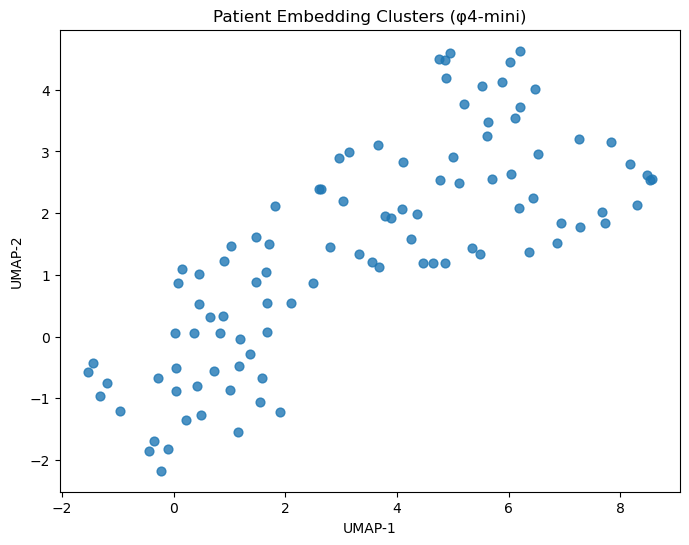

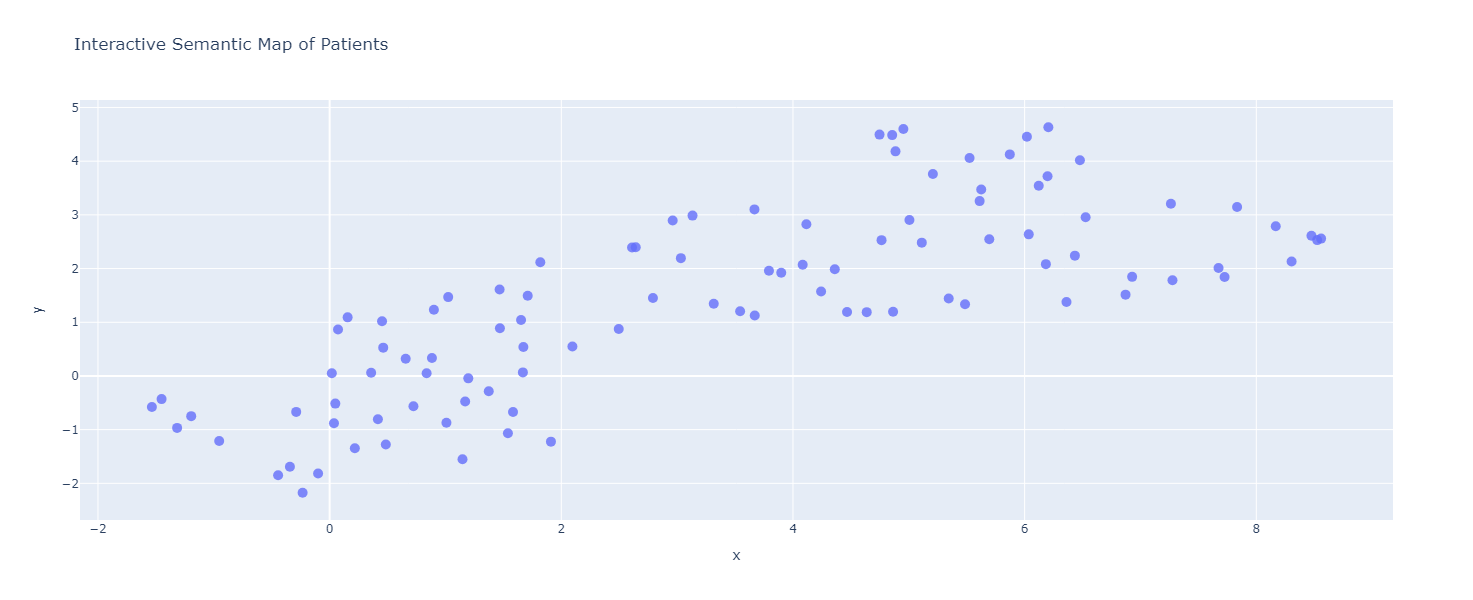

In [25]:
# --- Step 12: Visualize patient embeddings with optional query overlay ---
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

plt.figure(figsize=(8,6))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s=40, alpha=0.8)
plt.title("Patient Embedding Clusters (φ4-mini)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# Optional: Interactive hover view
df_plot = pd.DataFrame({
    "x": embedding_2d[:,0],
    "y": embedding_2d[:,1],
    "patient_id": patient_ids,
    "context_text": [r[1] for r in rows]
})

fig = px.scatter(
    df_plot,
    x="x",
    y="y",
    hover_data={"patient_id": True, "context_text": True},
    title="Interactive Semantic Map of Patients",
    width=800,
    height=600
)
fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.show()


# 12. Add NLP Semantic Search for Patients

In [30]:
import json
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.metrics.pairwise import cosine_similarity

def embed_query_ollama(text, model="phi4-mini"):
    emb = get_ollama_embedding(text, model=model)
    return np.array(emb, dtype=np.float32)
    
def semantic_search_fused(query_text, top_k=5):
    # Parse rule-based filters
    filters = parse_filters(query_text)
    candidate_ids = candidate_ids_from_filters(filters)

    if not candidate_ids:
        cur.execute("SELECT patient_id, embedding FROM patient_embeddings;")
    else:
        cur.execute("""
            SELECT patient_id, embedding
            FROM patient_embeddings
            WHERE patient_id = ANY(%s);
        """, (candidate_ids,))
    rows = cur.fetchall()

    if not rows:
        print("No candidates match the prefilters.")
        return None, pd.DataFrame()

    q_emb = embed_query_ollama(query_text).reshape(1, -1)

    ids, mats = [], []
    for pid, emb in rows:
        if isinstance(emb, str):
            emb = json.loads(emb)
        mats.append(np.array(emb, dtype=np.float32))
        ids.append(pid)
    E = np.vstack(mats)

    sims = cosine_similarity(q_emb, E)[0]
    order = np.argsort(-sims)[:top_k]
    top = [(ids[i], float(sims[i])) for i in order]

    results = []

    for pid, score in top:
        cur.execute("""
            SELECT first_name, last_name, gender, age, race, ethnicity,
                   sdoh_risk_score, insurance, smoking_status, deceased, death_date
            FROM patients WHERE patient_id = %s;
        """, (pid,))
        p = cur.fetchone()

        cur.execute("""
            SELECT substance, severity, reaction
            FROM allergies WHERE patient_id = %s
            ORDER BY severity DESC NULLS LAST, substance
            LIMIT 3;
        """, (pid,))
        alls = cur.fetchall()
        allergy_summary = "; ".join([f"{a[0]} ({a[1] or 'unknown'})" for a in alls]) if alls else "None"

        sdoh_bucket = "HIGH" if (p[6] and p[6] >= 0.70) else ("MEDIUM" if (p[6] and p[6] >= 0.40) else "LOW")

        # --- EXPLANATION SECTION ---
        explanations = []
        if filters["gender"]:
            explanations.append(f"gender={p[2]} {'✅' if p[2] and p[2].lower()==filters['gender'] else '❌'}")
        if filters["sdoh_bucket"]:
            explanations.append(f"SDOH={sdoh_bucket} {'✅' if sdoh_bucket==filters['sdoh_bucket'] else '❌'}")
        if filters["deceased"] is not None:
            explanations.append(f"deceased={p[9]} {'✅' if bool(p[9])==filters['deceased'] else '❌'}")
        if filters["recent_days"]:
            explanations.append(f"recent_check={filters['recent_days']}d window")
        explanation = "; ".join(explanations) if explanations else "No explicit filter matches"

        results.append({
            "Patient ID": pid,
            "Name": f"{p[0]} {p[1]}",
            "Gender": p[2],
            "Age": p[3],
            "SDOH": f"{sdoh_bucket} ({p[6]})",
            "Insurance": p[7],
            "Smoking": p[8],
            "Deceased": p[9],
            "Death Date": p[10],
            "Allergies (sample)": allergy_summary,
            "Similarity": round(score, 3),
            "Filter Match Summary": explanation
        })

    df = pd.DataFrame(results)

    print(f"\n🔎 Query: {query_text}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

    return q_emb, df


# 13. Filtering + fused semantic search

In [31]:
import re
from datetime import datetime, timedelta

def parse_filters(query_text):
    q = query_text.lower()

    filters = {
        "gender": None,
        "sdoh_bucket": None,
        "deceased": None,
        "recent_days": None
    }

    if "female" in q: filters["gender"] = "female"
    if "male" in q and "female" not in q: filters["gender"] = "male"

    if "high sdoh" in q or "high social risk" in q:   filters["sdoh_bucket"] = "HIGH"
    elif "low sdoh" in q or "low social risk" in q:   filters["sdoh_bucket"] = "LOW"
    elif "medium sdoh" in q or "medium social risk" in q: filters["sdoh_bucket"] = "MEDIUM"

    if "deceased" in q or "death" in q:
        filters["deceased"] = True
        if "recent" in q or "recently" in q:
            filters["recent_days"] = 180  # tweak as needed

    return filters
def candidate_ids_from_filters(filters):
    clauses, params = [], []

    if filters["gender"]:
        clauses.append("LOWER(gender) = %s")
        params.append(filters["gender"])

    if filters["sdoh_bucket"]:
        clauses.append("""
        CASE
          WHEN sdoh_risk_score >= 0.70 THEN 'HIGH'
          WHEN sdoh_risk_score >= 0.40 THEN 'MEDIUM'
          ELSE 'LOW'
        END = %s
        """)
        params.append(filters["sdoh_bucket"])

    if filters["deceased"] is True and filters["recent_days"]:
        days = int(filters["recent_days"])
        clauses.append(f"""
          COALESCE(deceased, FALSE) = TRUE
          AND NULLIF(death_date,'') IS NOT NULL
          AND death_date ~ '^[0-9]{{4}}-[0-9]{{2}}-[0-9]{{2}}$'
          AND TO_DATE(death_date, 'YYYY-MM-DD') >= (CURRENT_DATE - INTERVAL '{days} days')
        """)
    
    elif filters["deceased"] is True:
        clauses.append("COALESCE(deceased, FALSE) = TRUE")

    where_sql = ("WHERE " + " AND ".join(clauses)) if clauses else ""
    sql = f"SELECT patient_id FROM patients {where_sql};"
    cur.execute(sql, params)
    return [r[0] for r in cur.fetchall()]


# Run queries

In [40]:
q_emb, df_results = semantic_search_fused("patients experiencing headaches", top_k=5)

semantic_search_fused("recently deceased patient with respiratory reaction and low income", top_k=5)

semantic_search_fused("female patient deceased recently with severe drug allergy", top_k=5)



🔎 Query: patients experiencing headaches
╒══════════════════════════════════════╤═════════════════╤══════════╤═══════╤════════════╤═════════════╤═══════════╤════════════╤══════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤════════════════════════════╕
│ Patient ID                           │ Name            │ Gender   │   Age │ SDOH       │ Insurance   │ Smoking   │ Deceased   │ Death Date   │ Allergies (sample)                                                                                                                                                                │   Similarity │ Filter Match Summary       │
╞══════════════════════════════════════╪═════════════════╪══════════╪═══════╪════════════╪═════════════╪═══════════╪════════════╪══════════════╪════════════════════════════════════════════════════════════════════════════

(array([[-1.0271728 ,  1.163255  ,  0.9220183 , ...,  0.3373304 ,
         -0.07719056,  1.3530314 ]], shape=(1, 3072), dtype=float32),
                              Patient ID            Name  Gender  Age  \
 0  655771fe-48b9-438e-89a6-44a4d6ea1c49   Melissa Young  female   93   
 1  ffe637e8-1caf-4c2c-905c-59fdfa0615de  Victor Ramirez  female   56   
 
             SDOH Insurance  Smoking  Deceased  Death Date  \
 0  MEDIUM (0.47)   Private  Current      True  2025-10-30   
 1     LOW (0.35)  Medicaid  Current      True  2025-10-30   
 
                                   Allergies (sample)  Similarity  \
 0  Shellfish (severe); Administration Of First Do...       0.668   
 1                                               None       0.668   
 
                                 Filter Match Summary  
 0  gender=female ✅; deceased=True ✅; recent_check...  
 1  gender=female ✅; deceased=True ✅; recent_check...  )

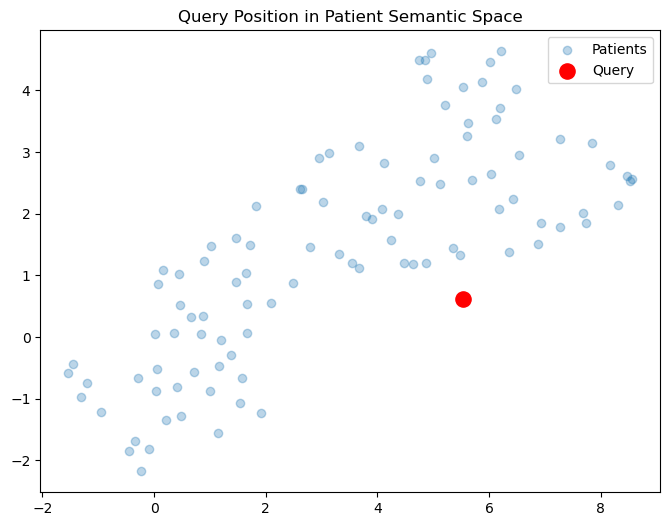

In [41]:
# --- Step 13: Project query embedding into same UMAP ---
q_emb = np.array(q_emb, dtype=np.float32).reshape(1, -1)
q_emb_2d = reducer.transform(q_emb)

plt.figure(figsize=(8,6))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], alpha=0.3, label='Patients')
plt.scatter(q_emb_2d[:,0], q_emb_2d[:,1], color='red', s=120, label='Query')
plt.legend()
plt.title("Query Position in Patient Semantic Space")
plt.show()
